In [ ]:
import pandas as pd
import dask.dataframe as dd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
N = 10_000_000
data = {
    'id': np.random.randint(1, 1000, N),
    'value': np.random.rand(N),
    'group': np.random.choice(['A', 'B', 'C', 'D'], N)
}

pandas_df = pd.DataFrame(data)
dask_df = dd.from_pandas(pandas_df, npartitions=10)
polars_df = pl.DataFrame(pandas_df)

In [ ]:
def measure_operation_time(operation):
    start_time = time.time()
    result = operation()
    end_time = time.time()
    return end_time - start_time, result

In [ ]:
def pandas_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: pandas_df.groupby('group').agg({'value': ['sum', 'mean']})
    )

    # Преобразование мультиуровневых названий столбцов в простые
    groupby_agg_df.columns = ['_'.join(col).strip() for col in groupby_agg_df.columns.values]
    groupby_agg_df = groupby_agg_df.reset_index()

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.merge(pandas_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df[merged_df['value'] > 0.5]
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort_values(by='value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.assign(cumsum=sorted_df['value'].cumsum())
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.assign(doubled_value=cumsum_df['value'] * 2)
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').size().reset_index(name='counts')
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.assign(log_value=np.log1p(groupby_agg_df['value_sum']))
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df['id'] = np.random.randint(1, 1000, len(new_column_df))

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop(columns=['id'])
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename(columns={'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.to_csv('pandas_test.csv', index=False)
    )

    return times

In [ ]:
def dask_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: dask_df.groupby('group').agg({'value': ['sum', 'mean']}).compute()
    )

    # Преобразование мультиуровневых названий столбцов в простые и сброс индекса
    groupby_agg_df.columns = ['_'.join(col).strip() for col in groupby_agg_df.columns.values]
    groupby_agg_df = groupby_agg_df.reset_index()

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.merge(pandas_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df[merged_df['value'] > 0.5]
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort_values(by='value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.assign(cumsum=sorted_df['value'].cumsum())
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.assign(doubled_value=cumsum_df['value'] * 2)
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').size().reset_index(name='counts')
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.assign(log_value=np.log1p(groupby_agg_df['value_sum']))
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df['id'] = np.random.randint(1, 1000, len(new_column_df))

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop(columns=['id'])
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename(columns={'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.to_csv('dask_test.csv', index=False)
    )

    return times

In [ ]:
def polars_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: polars_df.groupby('group').agg([
            pl.sum('value').alias('value_sum'),
            pl.mean('value').alias('value_mean')
        ])
    )

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.join(polars_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df.filter(pl.col('value') > 0.5)
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort('value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.with_columns([pl.col('value').cumsum().alias('cumsum')])
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.with_columns([(pl.col('value') * 2).alias('doubled_value')])
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').count().rename({'count': 'counts'})
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.with_columns([np.log1p(pl.col('value_sum')).alias('log_value')])
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df = new_column_df.with_columns([pl.lit(np.random.randint(1, 1000, len(new_column_df))).alias('id')])

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop('id')
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename({'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.write_csv('polars_test.csv')
    )

    return times

In [ ]:
pandas_times = pandas_operations()
for operation, time_taken in pandas_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 1.2802951335906982 seconds
merge: 2.998574733734131 seconds
filter: 0.6392490863800049 seconds
sort: 2.6704354286193848 seconds
cumsum: 0.24754595756530762 seconds
transform: 0.47147583961486816 seconds
groupby_count: 0.3525724411010742 seconds
new_column: 0.0006911754608154297 seconds
drop_column: 0.0006482601165771484 seconds
rename_columns: 0.0006210803985595703 seconds
to_csv: 0.0012903213500976562 seconds


In [ ]:
dask_times = dask_operations()
for operation, time_taken in dask_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 0.6845612525939941 seconds
merge: 2.105890989303589 seconds
filter: 0.6388072967529297 seconds
sort: 2.789430856704712 seconds
cumsum: 0.28655552864074707 seconds
transform: 0.4620940685272217 seconds
groupby_count: 0.6177067756652832 seconds
new_column: 0.0009670257568359375 seconds
drop_column: 0.0009100437164306641 seconds
rename_columns: 0.0008187294006347656 seconds
to_csv: 0.0015192031860351562 seconds


In [ ]:
polars_times = polars_operations()
for operation, time_taken in polars_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 0.6922895908355713 seconds
merge: 1.4775385856628418 seconds
filter: 0.2835512161254883 seconds
sort: 1.6967363357543945 seconds
cumsum: 0.09730100631713867 seconds
transform: 0.02654409408569336 seconds
groupby_count: 0.1500399112701416 seconds
new_column: 0.0006930828094482422 seconds
drop_column: 3.838539123535156e-05 seconds
rename_columns: 2.7418136596679688e-05 seconds
to_csv: 0.00045490264892578125 seconds


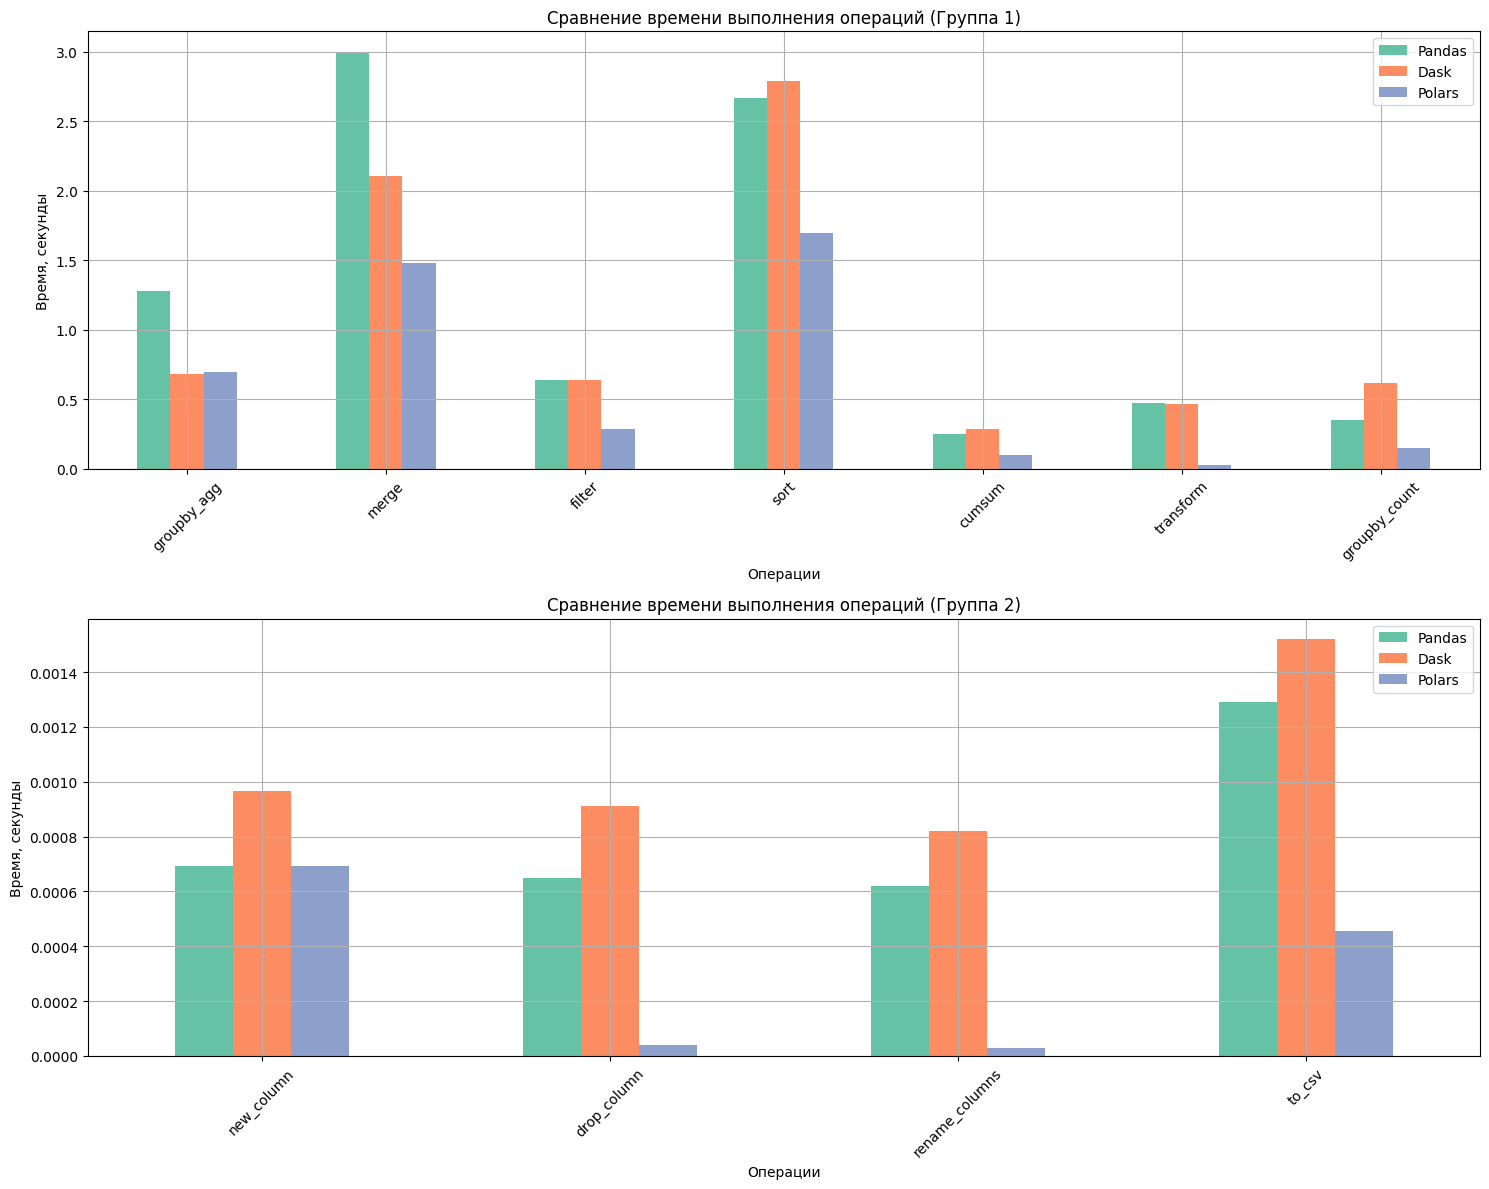

In [ ]:
palette = plt.get_cmap('Set2')

# Разбиваем операции на несколько групп для лучшей визуализации
group_1 = ['groupby_agg', 'merge', 'filter', 'sort', 'cumsum', 'transform', 'groupby_count']
group_2 = ['new_column', 'drop_column', 'rename_columns', 'to_csv']

# Создаем DataFrame для каждой группы
df1 = pd.DataFrame({op: [pandas_times[op], dask_times[op], polars_times[op]] for op in group_1}, index=["Pandas", "Dask", "Polars"]).T
df2 = pd.DataFrame({op: [pandas_times[op], dask_times[op], polars_times[op]] for op in group_2}, index=["Pandas", "Dask", "Polars"]).T

# Построение графиков для каждой группы
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
df1.plot(kind='bar', ax=plt.gca(), color=[palette(i) for i in range(len(df1.columns))])
plt.title('Сравнение времени выполнения операций (Группа 1)')
plt.ylabel('Время, секунды')
plt.xlabel('Операции')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 1, 2)
df2.plot(kind='bar', ax=plt.gca(), color=[palette(i) for i in range(len(df2.columns))])
plt.title('Сравнение времени выполнения операций (Группа 2)')
plt.ylabel('Время, секунды')
plt.xlabel('Операции')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

## Сравнительный анализ времени выполнения операций

### Выводы:

- **Группировка и агрегация**: Dask и Polars показывают схожее время выполнения и опережают Pandas, что указывает на их большую эффективность в этих операциях.

- **Слияние**: Polars значительно превосходит Pandas и Dask, что может быть связано с оптимизациями при работе с соединениями таблиц.

- **Фильтрация**: Polars снова показывает лучший результат, что может указывать на более эффективное выполнение условных запросов.

- **Сортировка**: Polars опережает Dask и Pandas, предположительно благодаря оптимизированному алгоритму сортировки.

- **Кумулятивная сумма**: Polars на порядок быстрее обоих конкурентов, что может быть важным фактором при выборе инструмента для работы с временными рядами или накопительными итогами.

- **Преобразование данных**: Polars выделяется своей производительностью, что делает его предпочтительным для операций, требующих трансформации больших объемов данных.

- **Группировка и подсчет**: Здесь Polars также опережает конкурентов, особенно Dask, который показывает наихудшее время среди трех.

- **Добавление нового столбца**: Время выполнения операции минимально для всех трех библиотек, что делает её менее значимой для сравнения производительности.

- **Удаление столбца**: Polars выигрывает с незначительным отрывом, но все библиотеки показывают сопоставимые результаты.

- **Переименование столбцов**: Самая быстрая операция для всех библиотек, с Polars на первом месте, но разница минимальна.

- **Сохранение в файл CSV**: Polars заметно опережает Pandas и Dask, что делает его предпочтительным вариантом для задач, связанных с экспортом данных.

### Общий вывод:
Polars обеспечивает лучшую производительность по большинству операций, особенно при обработке больших наборов данных. Dask лучше справляется с некоторыми задачами, чем Pandas, и может быть предпочтительнее при распределенной обработке данных. Pandas, хотя и уступает по скорости, может быть удобен для анализа данных в условиях с ограниченными вычислительными ресурсами или когда требуется широкая поддержка экосистемы Python.